In [2]:
import os
import numpy as np
import librosa
import pywt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer

# -----------------------------
# Feature Extraction Functions
# -----------------------------

def extract_mfcc(y, sr, n_mfcc=13):
    return np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc), axis=1)

def extract_pitch_swipe(y, sr):
    pitches, mags = librosa.piptrack(y=y, sr=sr)
    avg_pitch = np.mean(pitches[mags > np.median(mags)])
    return np.array([avg_pitch if not np.isnan(avg_pitch) else 0])

def extract_pitch_class_distribution(y, sr):
    return np.mean(librosa.feature.tonnetz(y=y, sr=sr), axis=1)

def extract_chroma(y, sr):
    return np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)

def extract_dwt(y):
    coeffs = pywt.wavedec(y, 'db1', level=3)
    return np.array([np.mean(c) for c in coeffs])

def extract_cwt(y):
    scales = np.arange(1, 21)
    coeffs, _ = pywt.cwt(y, scales, 'morl')
    return np.mean(coeffs, axis=1)

def extract_features(y, sr):
    return np.hstack([
        extract_mfcc(y, sr),
        extract_pitch_swipe(y, sr),
        extract_pitch_class_distribution(y, sr),
        extract_chroma(y, sr),
        extract_dwt(y),
        extract_cwt(y)
    ])

# -----------------------------
# Load Data
# -----------------------------

def load_dataset(path='dataset', sr=22050):
    X, y = [], []
    for raga in os.listdir(path):
        folder = os.path.join(path, raga)
        if not os.path.isdir(folder): continue
        for file in os.listdir(folder):
            if not file.endswith('.wav'): continue
            y_audio, _ = librosa.load(os.path.join(folder, file), sr=sr)
            features = extract_features(y_audio, sr)
            X.append(features)
            y.append(raga)
    return np.array(X), np.array(y)

# -----------------------------
# Attention Layer Definition
# -----------------------------

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# -----------------------------
# CNN + BiLSTM + Attention Model
# -----------------------------

def build_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(Attention())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# -----------------------------
# Train & Evaluate
# -----------------------------

# Load and prepare data
X, y = load_dataset('dataset')
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Reshape for CNN input: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Treat each feature dimension as a timestep

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build and train model
model = build_model(input_shape=X.shape[1:], num_classes=len(le.classes_))
model.summary()
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 14, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,824 (518.84 KB)

 Trainable params: 132,824 (518.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3199 - loss: 1.9754 - val_accuracy: 0.6779 - val_loss: 1.0356
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7307 - loss: 0.8975 - val_accuracy: 0.8673 - val_loss: 0.4664
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8517 - loss: 0.4761 - val_accuracy: 0.8878 - val_loss: 0.3875
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8988 - loss: 0.3259 - val_accuracy: 0.9252 - val_loss: 0.2527
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9033 - loss: 0.3074 - val_accuracy: 0.9361 - val_loss: 0.2185
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9281 - loss: 0.2230 - val_accuracy: 0.9397 - val_loss: 0.2032
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9474 - loss: 0.1647 - val_accuracy: 0.9385 - val_loss: 0.1791
Epoch 8/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9547 - loss: 0.1474 - val_accu

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


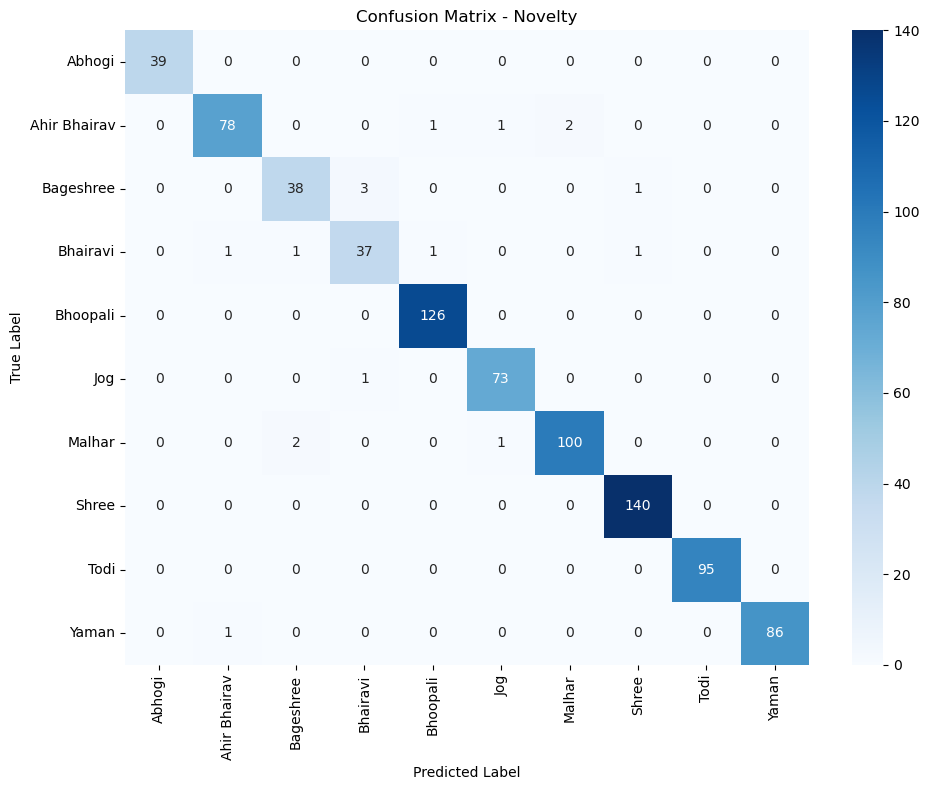


Accuracy: 0.9794933655006032
Precision (macro): 0.9728284275836753
Recall (macro): 0.9704286461367962
F1 Score (macro): 0.9715793604714855

Classification Report:
              precision    recall  f1-score   support

      Abhogi       1.00      1.00      1.00        39
Ahir Bhairav       0.97      0.95      0.96        82
   Bageshree       0.93      0.90      0.92        42
    Bhairavi       0.90      0.90      0.90        41
    Bhoopali       0.98      1.00      0.99       126
         Jog       0.97      0.99      0.98        74
      Malhar       0.98      0.97      0.98       103
       Shree       0.99      1.00      0.99       140
        Todi       1.00      1.00      1.00        95
       Yaman       1.00      0.99      0.99        87

    accuracy                           0.98       829
   macro avg       0.97      0.97      0.97       829
weighted avg       0.98      0.98      0.98       829



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Predict test labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_  # Raga class names

# Step 3: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Novelty')
plt.tight_layout()
plt.show()

# Step 4: Evaluation metrics
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: Full report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))